<a href="https://colab.research.google.com/github/mz-zarei/NBEB-Sensitivity/blob/main/NBEB_sensitivity_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nbeb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm

def PMD(results):
    PMD_test = 0
    for HS_level in [0.1]:
        PMD_test += results[results['true_rank'] > 1-HS_level]['PSI_true'].sum() - results[results['rank'] > 1-HS_level]['PSI_true'].sum()
    return round(PMD_test,3)

def FI(results):
    FI_test = 0
    for HS_level in [0.1]:
        FI_test += 1-results[(results['true_rank'] > 1- HS_level) & (results['rank'] > 1- HS_level)].count()[0]/results[(results['rank'] > 1- HS_level)].count()[0]
    return round(FI_test, 3)

def truncnorm(AADT_list, noise):
    AADT_n = []
    
    for mean in AADT_list:
        if noise > 0:
            sd = mean * noise
            minS = max(40, mean - 2*sd)
            maxS = mean + 2*sd
            while True:
                s = np.random.normal(mean, sd)
                if minS <= s <= maxS:
                    break
            AADT_n.append(s)  
        else:
            AADT_n.append(mean)


    return AADT_n


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
### Upload data
London_data = pd.read_excel('/content/London_Python_Data.xlsx')
London_data = London_data[London_data['Year'] == 2016].copy()
# London_data = London_data[London_data['Group'] == 3].copy()

London_data['log_Fmaj'] = np.log(London_data['Fmaj'])
London_data['log_Fmin'] = np.log(London_data['Fmin'])
London_data['log_Ftot'] = np.log(London_data['Ftot'])
features = ['log_Ftot'] #  ['log_Fmaj', 'log_Fmin'] # 
features_n = ['log_Ftot_n'] # ['log_Fmaj_n', 'log_Fmin_n'] # 
London_data.reset_index(inplace=True, drop= True)
London_data.describe()

,Group,Year,Fmaj,Fmin,Ftot,Fatal,Non-fatal,PDO,FI,Obs,log_Fmaj,log_Fmin,log_Ftot
count,865.000000,865.0,865.000000,865.000000,865.000000,865.0,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000
mean,2.475145,2016.0,14793.060116,3625.870520,18418.930636,0.0,0.634682,3.122543,0.634682,3.757225,9.088870,7.429977,9.340081
std,1.260013,0.0,11391.583183,4995.177649,14438.160766,0.0,1.205965,6.131753,1.205965,7.028630,1.232232,1.334653,1.170956
min,1.000000,2016.0,168.000000,7.000000,306.000000,0.0,0.000000,0.000000,0.000000,0.000000,5.123964,1.945910,5.723585
25%,1.000000,2016.0,3911.000000,677.000000,4968.000000,0.0,0.000000,0.000000,0.000000,0.000000,8.271548,6.517671,8.510773
50%,3.000000,2016.0,12851.000000,1805.000000,15997.000000,0.0,0.000000,1.000000,0.000000,1.000000,9.461177,7.498316,9.680156
75%,4.000000,2016.0,24108.000000,4297.000000,28340.000000,0.0,1.000000,3.000000,1.000000,4.000000,10.090299,8.365672,10.252030
max,4.000000,2016.0,46121.000000,33450.000000,73035.000000,0.0,8.000000,56.000000,8.000000,62.000000,10.739024,10.417807,11.198694


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Group 1 with Dispersion: 0.19903761417089164 
                Results: Generalized linear model
Model:              GLM              AIC:            1796.6751 
Link Function:      log              BIC:            -1295.8212
Dependent Variable: Obs              Log-Likelihood: -896.34   
Date:               2022-06-03 12:04 LL-Null:        -1188.8   
No. Observations:   315              Deviance:       504.73    
Df Model:           1                Pearson chi2:   513.      
Df Residuals:       313              Scale:          1.0000    
Method:             IRLS                                       
---------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
---------------------------------------------------------------
const       -15.2708   0.8276 -18.4513 0.0000 -16.8929 -13.6487
log_Ftot      1.6774   0.0801  20.9398 0.0000   1.5204   1.8345

Group 2 with Dispersion: 0.648923075206246 
               Results: Gen

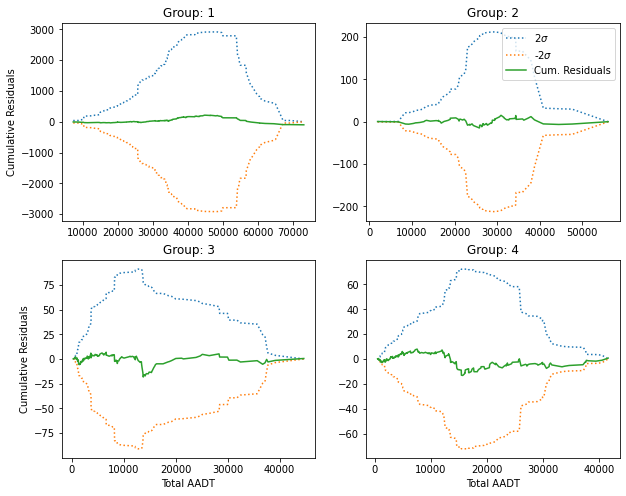

In [6]:
from IPython.core.pylabtools import figsize
# Fit the true NB models
nb_models = []
alpha_list = []
fig, ax = plt.subplots(2,2, figsize=(10,8))
for g in range(1,5):
        London_data_G = London_data[London_data['Group'] == g].copy()
        London_data_G.sort_values(by='Ftot', ascending=True, inplace=True)
        London_data_G.reset_index(drop=True, inplace=True)

        NB_model_b, alpha = nbeb.fitNB(London_data_G,features=features, y_name='Obs')
        # CURE Plots
        London_data_G['y_pred'] = nbeb.predNB(NB_model_b, London_data_G, features, y_name='Obs')
        London_data_G['res'] = London_data_G['y_pred'] - London_data_G['Obs']
        London_data_G['res_sq'] = (London_data_G['y_pred'] - London_data_G['Obs'])**2
        London_data_G['e1'] = London_data_G['res'].cumsum()
        London_data_G['e2'] = London_data_G['res_sq'].cumsum()
        London_data_G['e3'] = London_data_G['e2']*((1 - London_data_G['e2']/London_data_G['e2'][len(London_data_G['e2'])-1]))
        (i,j) = (0, g-1) if g<3 else (1, g-3)
        ax[i,j].plot(London_data_G['Ftot'], London_data_G['e3'], linestyle = 'dotted', label = "2$\sigma$")
        ax[i,j].plot(London_data_G['Ftot'], -London_data_G['e3'], linestyle = 'dotted', label = "-2$\sigma$")
        ax[i,j].plot(London_data_G['Ftot'], London_data_G['e1'], label = "Cum. Residuals")
        
        
        ax[i,j].set_title(f'Group: {g}')
        print(f'Group {g} with Dispersion: {alpha}', "\n", NB_model_b.summary2())
        # print(London_data_G['Obs'].mean(), len(London_data_G['Ftot']))
        nb_models.append(NB_model_b)
        alpha_list.append(alpha)
ax[0,1].legend(loc='upper right')
ax[1,0].set_xlabel('Total AADT')
ax[1,1].set_xlabel('Total AADT')

ax[0,0].set_ylabel('Cumulative Residuals')
ax[1,0].set_ylabel('Cumulative Residuals')

fig.savefig('cure.pdf')

In [87]:
# Simulate the process of modifying AADT values and measure DPSI
noiseList = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.50]

FI_list  = []
PMD_list = []
FI_noNoise_list  = []
PMD_noNoise_list = []
nosie_list = []

for j in tqdm(range(200)):
    simulated_data = pd.DataFrame()
    for NB_model_b, alpha, g in zip(nb_models, alpha_list, [1,2,3,4]):
        London_data_G = London_data[London_data['Group'] == g].copy()
        simulated_data_g = nbeb.simulateCrashData_X(London_data_G[features], 
                                                constant = NB_model_b.params[0], 
                                                coef_vector = [NB_model_b.params[1]], 
                                                data_size =  len(London_data_G[features]), 
                                                error_mean = 1.0,
                                                error_var = alpha,
                                                replacement = False)
        NB_model, alpha                  = nbeb.fitNB(simulated_data_g,features=features, y_name='Obs')
        simulated_data_g['Group']        = g
        simulated_data_g['NB_pred']      = nbeb.predNB(NB_model, simulated_data_g, features, 'Obs')
        simulated_data_g['NB_pred_true'] = nbeb.predNB(NB_model_b, simulated_data_g, features, 'Obs')
        simulated_data_g['w']            = 1 / (1+alpha * simulated_data_g['NB_pred'])
        
        simulated_data_g['EB'] = simulated_data_g['w'] * simulated_data_g['NB_pred']  + (1-simulated_data_g['w']) * simulated_data_g['Obs']
        simulated_data_g['PSI'] = simulated_data_g['EB'] - simulated_data_g['NB_pred']
        simulated_data_g.loc[simulated_data_g['PSI']<0,'PSI'] = 0

        simulated_data = pd.concat([simulated_data, simulated_data_g])

    simulated_data['Ftot'] = np.exp(simulated_data['log_Ftot'])
    simulated_data['rank'] = simulated_data['PSI'].rank(pct=True)
    simulated_data['PSI_true'] = simulated_data['Lambda'] - simulated_data['NB_pred_true']
    simulated_data.loc[simulated_data['PSI_true']<0, 'PSI_true'] = 0
    simulated_data['true_rank'] = simulated_data['PSI_true'].rank(pct=True)

    FI_NoNoise = FI(simulated_data)
    PMD_NoNoise = PMD(simulated_data)
  

    for i in range(5):
        for noise in noiseList:
            simulated_data['Ftot_n'] = truncnorm(simulated_data['Ftot'].values, noise)
            simulated_data['log_Ftot_n'] = np.log(simulated_data['Ftot_n'])

            simulated_data_n = pd.DataFrame()
            for g in [1,2,3,4]:
                simulated_data_g = simulated_data[simulated_data['Group'] == g].copy()
                NB_model, alpha = nbeb.fitNB(simulated_data_g,features=features_n, y_name='Obs')
                simulated_data_g['NB_pred'] = nbeb.predNB(NB_model, simulated_data_g, features_n, 'Obs')
                simulated_data_g['w'] = 1 / (1+alpha * simulated_data_g['NB_pred'])
                # change EB be PSI
                simulated_data_g['EB'] = simulated_data_g['w'] * simulated_data_g['NB_pred']  + (1-simulated_data_g['w']) * simulated_data_g['Obs']
                simulated_data_g['PSI'] = simulated_data_g['EB'] - simulated_data_g['NB_pred'] 
                simulated_data_g.loc[simulated_data_g['PSI']<0,'PSI'] = 0

                simulated_data_n = pd.concat([simulated_data_n, simulated_data_g])
            
            simulated_data['rank'] = simulated_data_n['PSI'].rank(pct=True)
            
            FI_test  = FI(simulated_data)
            PMD_test = PMD(simulated_data)
            
            FI_list.append((FI_test))
            PMD_list.append((PMD_test))

            FI_noNoise_list.append((FI_NoNoise))
            PMD_noNoise_list.append((PMD_NoNoise))

            nosie_list.append(noise)

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
100%|██████████| 200/200 [22:08<00:00,  6.64s/it]


In [88]:
# Creating the error result dataframe
Test_results = pd.DataFrame()

Test_results['COV (%)'] = nosie_list
Test_results['COV (%)'] = Test_results['COV (%)'] * 100

Test_results['FI'] = FI_list
Test_results['FI_NoNoise'] = FI_noNoise_list
Test_results['FI change (%)'] = (Test_results['FI']-Test_results['FI_NoNoise'])/Test_results['FI_NoNoise'] * 100

Test_results['DPSI'] = PMD_list
Test_results['DPSI_NoNoise'] = PMD_noNoise_list
Test_results['Loss Change ($)'] = 15000*(Test_results['DPSI']-Test_results['DPSI_NoNoise'])
Test_results['DPSI AVG Change (%)'] = (Test_results['DPSI']-Test_results['DPSI_NoNoise'])/Test_results['DPSI_NoNoise'] * 100


Test_results.to_excel('res.xlsx')
Test_results

,COV (%),FI,FI_NoNoise,FI change (%),DPSI,DPSI_NoNoise,Loss Change ($),DPSI AVG Change (%)
0,0.0,0.322,0.322,0.000000,81.596,81.596,0.0,0.000000
1,5.0,0.322,0.322,0.000000,85.224,81.596,54420.0,4.446296
2,10.0,0.299,0.322,-7.142857,66.319,81.596,-229155.0,-18.722732
3,15.0,0.310,0.322,-3.726708,90.561,81.596,134475.0,10.987058
4,20.0,0.322,0.322,0.000000,77.867,81.596,-55935.0,-4.570077
...,...,...,...,...,...,...,...,...
10995,30.0,0.379,0.287,32.055749,92.221,60.089,481980.0,53.474014
10996,35.0,0.356,0.287,24.041812,79.137,60.089,285720.0,31.699646
10997,40.0,0.379,0.287,32.055749,101.389,60.089,619500.0,68.731382
10998,45.0,0.356,0.287,24.041812,78.032,60.089,269145.0,29.860707


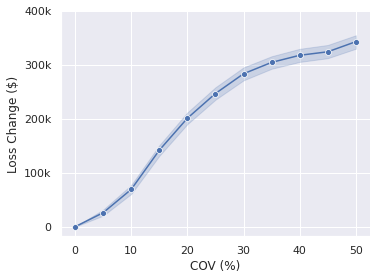

In [89]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

Test_results = pd.read_excel('/content/res.xlsx')

sns.set(font_scale=1)
fig = sns.relplot(data=Test_results, x="COV (%)", y="Loss Change ($)", kind="line", height=4, aspect=1.4, marker = 'o')
plt.yticks([ 0, 100000, 200000,300000, 400000], ['0','100k','200k', '300k', '400k'])
fig.savefig('Loss_L.pdf')

plt.show()



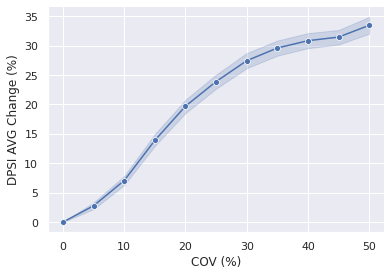

In [90]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

Test_results = pd.read_excel('/content/res.xlsx')
sns.set(font_scale=1)

fig = sns.relplot(data=Test_results, x="COV (%)", y="DPSI AVG Change (%)", kind="line", height=4, aspect=1.4, marker = 'o')

fig.savefig('DPSI_L.pdf')

plt.show()

In [91]:
# Simulate the process of modifying AADT values and measure MAPE for SPF coefs
noiseList = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.50]

MAPE_b0_list  = []
MAPE_b1_list = []
MAPE_alpha_list = []
MAPE_b0_noNoise_list  = []
MAPE_b1_noNoise_list = []
MAPE_alpha_noNoise_list = []

nosie_list = []
group_list = []

for j in tqdm(range(50)):
    simulated_data = pd.DataFrame()
    for NB_model_b, alpha_b, g in zip(nb_models, alpha_list, [1,2,3,4]):
        London_data_G = London_data[London_data['Group'] == g].copy()
        simulated_data_g = nbeb.simulateCrashData_X(London_data_G[features], 
                                                constant = NB_model_b.params[0], 
                                                coef_vector = [NB_model_b.params[1]], 
                                                data_size =  len(London_data_G[features]), 
                                                error_mean = 1.0,
                                                error_var = alpha_b,
                                                replacement = False)
        # Fit NB model to simulated data
        NB_model, alpha = nbeb.fitNB(simulated_data_g,features=features, y_name='Obs')
        # Calculate MAPE for coefs/alpha with no noise
        MAPE_b0_noNoise = np.abs(NB_model_b.params[0] - NB_model.params[0])/NB_model_b.params[0]
        MAPE_b1_noNoise = np.abs(NB_model_b.params[1] - NB_model.params[1])/NB_model_b.params[1]
        MAPE_alpha_noNoise = np.abs(alpha_b - alpha)/alpha_b

        simulated_data_g['Group'] = g
        simulated_data_g['Ftot']  = np.exp(simulated_data_g['log_Ftot'])
        for noise in noiseList:

            simulated_data_g['Ftot_n'] = truncnorm(simulated_data_g['Ftot'].values, noise)
            simulated_data_g['log_Ftot_n'] = np.log(simulated_data_g['Ftot_n'])

            NB_model_n, alpha_n = nbeb.fitNB(simulated_data_g,features=features_n, y_name='Obs')

            MAPE_b0    = np.abs((NB_model_b.params[0] - NB_model_n.params[0])/NB_model_b.params[0])*100
            MAPE_b1    = np.abs((NB_model_b.params[1] - NB_model_n.params[1])/NB_model_b.params[1])*100
            MAPE_alpha = np.abs(alpha_b - alpha_n)/alpha_b * 100

            MAPE_b0_list    += [MAPE_b0]
            MAPE_b1_list    += [MAPE_b1]
            MAPE_alpha_list += [MAPE_alpha]

            MAPE_b0_noNoise_list    += [MAPE_b0_noNoise]
            MAPE_b1_noNoise_list    += [MAPE_b1_noNoise]
            MAPE_alpha_noNoise_list += [MAPE_alpha_noNoise]

            nosie_list += [noise]
            group_list += [g]


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
100%|██████████| 50/50 [00:52<00:00,  1.06s/it]


In [111]:
# Creating the MAPE result dataframe
Test_results2 = pd.DataFrame()

Test_results2['Group'] = group_list

Test_results2['COV (%)'] = nosie_list
Test_results2['COV (%)'] = Test_results2['COV (%)'] * 100

Test_results2['MAPE b0 (%)'] = MAPE_b0_list
Test_results2['MAPE b0 NoNoise'] = MAPE_b0_noNoise_list

Test_results2['MAPE b1 (%)'] = MAPE_b1_list
Test_results2['MAPE b1 NoNoise'] = MAPE_b1_noNoise_list

Test_results2['MAPE Dispersion (%)'] = MAPE_alpha_list
Test_results2['MAPE Dispersion NoNoise'] = MAPE_alpha_noNoise_list

Test_results2.to_excel('res2.xlsx')
Test_results2.head()

,Group,COV (%),MAPE b0 (%),MAPE b0 NoNoise,MAPE b1 (%),MAPE b1 NoNoise,MAPE Dispersion (%),MAPE Dispersion NoNoise
0,1,0.0,2.509040,-0.02509,2.203139,0.022031,18.175780,0.181758
1,1,5.0,3.793266,-0.02509,3.303892,0.022031,14.775834,0.181758
2,1,10.0,7.728311,-0.02509,6.785966,0.022031,9.023086,0.181758
3,1,15.0,12.614394,-0.02509,11.031305,0.022031,11.736064,0.181758
4,1,20.0,17.406107,-0.02509,15.223933,0.022031,12.269357,0.181758


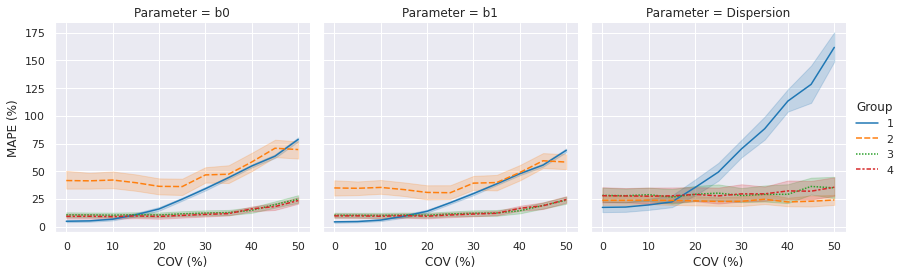

In [130]:
from matplotlib import colors
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set(font_scale=1)
sns.color_palette("tab10")

res = pd.read_excel('/content/res2.xlsx')
res. rename(columns = {'MAPE b0 (%)':'b0','MAPE b1 (%)':'b1', 'MAPE Dispersion (%)':'Dispersion'}, inplace = True)

res_unpivot = pd.melt(res, id_vars=['Group', 'COV (%)'], value_vars=['b0', 'b1', 'Dispersion'])
res_unpivot. rename(columns = {'value':'MAPE (%)', 'variable':'Parameter'}, inplace = True)

f = sns.relplot(data=res_unpivot, x='COV (%)', y='MAPE (%)', kind="line", 
            col= 'Parameter', style='Group',hue='Group',palette='tab10',
            height=4, aspect=1)

f.savefig('coef_MAPE.pdf')
plt.show()